[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202320_IMAGENES_Y_VISION/blob/main/Laboratorio%203/Practica/MISIS4825-M%26V2023%20-%20LAB3%20-%20Práctica.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

Práctica No. 3
==============

# Introducción a TensorFlow y Keras

Objetivos
---------

-   Introducir a los fundamentos de TensorFlow y Keras. A través de conceptos claves como operaciones, capas y modelos.
-   Implementar una red neuronal simple para clasificación de imágenes.
-   Entrenar y evaluar modelos con la ayuda de funciones de callback que permiten monitorear el entrenamiento.

Contexto
--------

TensorFlow es una biblioteca de código abierto para Deep Learning, desarrollada por Google Brain Team. TensorFlow proporciona una plataforma robusta para implementar y desplegar modelos de aprendizaje automático en diversas plataformas.

Keras, por otro lado, es una API de alto nivel para la construcción y entrenamiento de modelos de aprendizaje profundo. Integrada con TensorFlow, Keras facilita el diseño de redes neuronales con una interfaz más intuitiva y amigable. Ofrece bloques de construcción de modelos como capas, activaciones y optimizadores, permitiendo una rápida experimentación y desarrollo.

Datos: [5 Flower Types Classification Dataset](https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset)

In [1]:
# Importación de librerías
import tensorflow as tf
from tensorflow import keras

# Descarga y Preparación del Dataset de Kaggle

In [2]:
# Instalación de Kaggle
!pip install kaggle --quiet

In [3]:
import json
import os

# Credenciales desde kaggle.json
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Autenticar y descargar el dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kausthubkannan/5-flower-types-classification-dataset', path='data', unzip=True)

# Exploración de datos

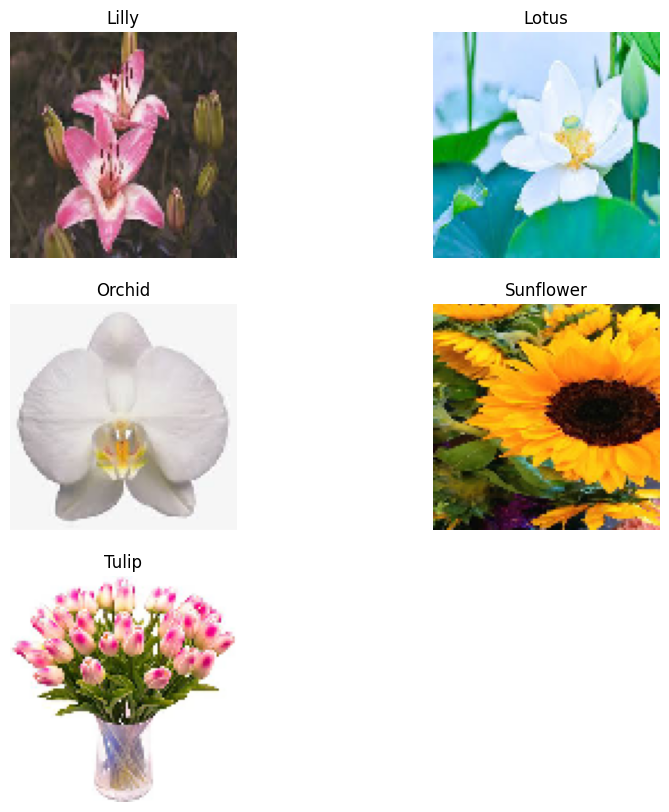

In [4]:
import os
import matplotlib.pyplot as plt

# Cargar y visualizar algunas imágenes del dataset
data_dir = 'data/flower_images'
flower_categories = os.listdir(data_dir)

# Visualizar una imagen de cada categoría
plt.figure(figsize=(10, 10))
for i, category in enumerate(flower_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100)) # Se carga la imagen como un objeto de tipo PIL (Python Imaging Library)
    plt.subplot(3, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [5]:
# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in flower_categories:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

Total de imágenes: 5000
Número de imágenes por categoría:
Lilly: 1000
Lotus: 1000
Orchid: 1000
Sunflower: 1000
Tulip: 1000


# Preprocesamiento de Datos

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Como en este caso solamente tenemos un directorio con todas las imágenes
# Para hacer una división de los datos en entrenamiento, prueba y validación
# Podemos realizarlo con los paths de los archivos
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']] # Directorio con todas las imágenes
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths] # Nombre de la carpeta de cada imagen

# Crear un DataFrame con rutas de archivo y etiquetas
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir los datos en entrenamiento, prueba y validación
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42) # 10% de prueba y 20% de validación

# Crear generadores de imágenes
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Leer imágenes de los directorios y generar batches de datos
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32)
test_gen = test_val_datagen.flow_from_dataframe(test_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32, shuffle=False)
val_gen = test_val_datagen.flow_from_dataframe(val_df, x_col='filepath', y_col='label', target_size=(100, 100), batch_size=32, shuffle=False)

Found 3499 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


# Construcción del Modelo de Red Neuronal

En Keras, un modelo se construye como una secuencia de capas. Cada capa tiene su función específica, como la activación, la normalización, la convolución, etc. La API de Keras proporciona una amplia gama de capas para construir modelos de redes neuronales.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# Creación del modelo
model = Sequential([
    Flatten(input_shape=(100, 100, 3)), # Transforma las imágenes en un vector 1D
    Dense(512, activation='relu'),
    Dropout(0.2), # Regularización. Desactiva el 20% de las neuronas de la capa anterior
    Dense(256, activation='relu'),
    Dense(len(flower_categories), activation='softmax')
])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 512)               15360512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 15,493,125
Trainable params: 15,493,125
Non-trainable params: 0
_________________________________________________________________


# Compilación del Modelo

Al compilar un modelo en Keras, debemos especificar el optimizador, la función de pérdida y las métricas que se utilizarán.

- **Optimizador:** Determina cómo se actualizan los pesos de la red durante el entrenamiento. Ejemplos comunes incluyen SGD, RMSprop, y Adam.

- **Función de Pérdida:** Mide qué tan bien el modelo está haciendo predicciones. Para la clasificación multiclase, se suele utilizar 'categorical_crossentropy'.

- **Métricas:** Se utilizan para monitorear el rendimiento del modelo durante el entrenamiento y la prueba. 'accuracy' es una métrica común para la clasificación.

In [8]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks en Keras

Los callbacks son objetos que se pasan a un modelo para personalizar y extender el comportamiento del entrenamiento. Pueden ser utilizados para:

- Escribir registros de TensorBoard después de cada lote durante el entrenamiento.
- Realizar evaluaciones de validación periódicas para deerminar una posible interrupción temprana. (EarlyStopping)
- Alterar la tasa de aprendizaje del modelo dinámicamente. (ReduceLROnPlateau)
- Salvar el mejor modelo durante el entrenamiento. (ModelCheckpoint)


In [9]:
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint

# Model Checkpoint: Guarda el mejor modelo durante el entrenamiento.
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min') # Nos aseuramos que la loss function de los datos de validación sea la menor

# EarlyStopping: Detiene el entrenamiento cuando una métrica monitoreada ha dejado de mejorar.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# TensorBoard: Herramienta de visualización para entender, depurar y optimizar el modelo.
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

# Lista de callbacks
callbacks = [model_checkpoint, early_stopping, tensorboard, reduce_lr]

# Entrenamiento del Modelo

In [10]:
# Entrenar el modelo
with tf.device('/device:GPU:0'): 
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50
110/110 [==============================] - 13s 113ms/step - loss: 4.9175 - accuracy: 0.3081 - val_loss: 1.4028 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 13s 114ms/step - loss: 1.3988 - accuracy: 0.3970 - val_loss: 1.3473 - val_accuracy: 0.4210 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 12s 110ms/step - loss: 1.4040 - accuracy: 0.3701 - val_loss: 1.4009 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 12s 107ms/step - loss: 1.3803 - accuracy: 0.3915 - val_loss: 1.3482 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 12s 108ms/step - loss: 1.3820 - accuracy: 0.3861 - val_loss: 1.3445 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 12s 110ms/step - loss: 1.3283 - accuracy: 0.4130 - val_loss: 1.2990 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 7/50
110/110 [==============================] 

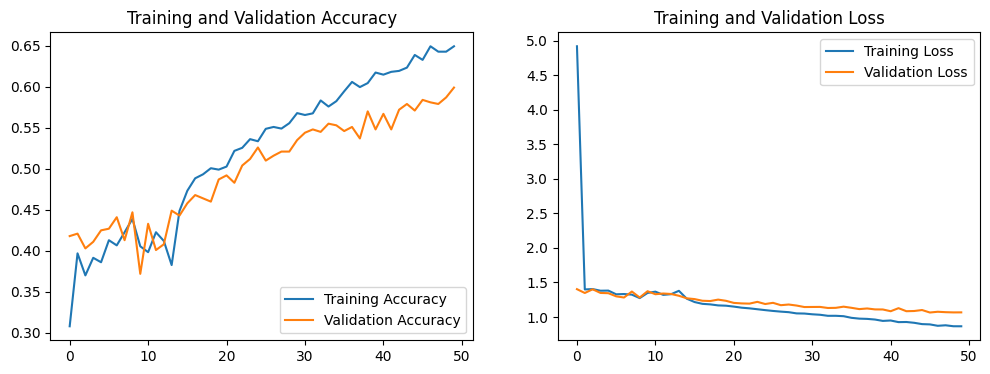

In [11]:
# Visualización de la progresión del entrenamiento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

16/16 [==============================] - 1s 69ms/step


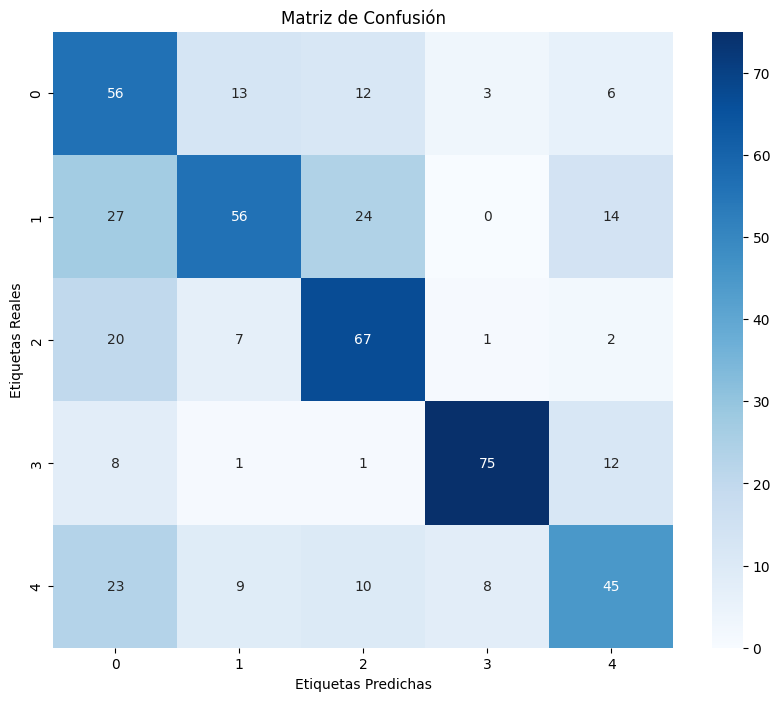

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# Definir el generador en la misma configuración que el de entrenamiento
test_gen.reset()

# Realizar predicciones
predicciones = model.predict(test_gen, verbose=1)

# Convertir las predicciones en etiquetas
y_pred = np.argmax(predicciones, axis=1)

# Obtener las etiquetas reales
y_test = test_gen.classes

# Crear la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión. Gama de azules
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

In [17]:
# Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=flower_categories))

              precision    recall  f1-score   support

       Lilly       0.42      0.62      0.50        90
       Lotus       0.65      0.46      0.54       121
      Orchid       0.59      0.69      0.64        97
   Sunflower       0.86      0.77      0.82        97
       Tulip       0.57      0.47      0.52        95

    accuracy                           0.60       500
   macro avg       0.62      0.60      0.60       500
weighted avg       0.62      0.60      0.60       500



- ¿Ayudaría a mejorar el rendimiento del modelo si aumentamos el número de épocas? 
- ¿Qué pasa si aumentamos el número de capas y neuronas en la red?
- ¿Si eliminamos la capa de dropout, el modelo se sobreajustaría?

# Introducción a TensorBoard

TensorBoard es una herramienta poderosa para visualizar diferentes aspectos del entrenamiento y la arquitectura del modelo. Permite ver métricas como la precisión y la pérdida durante el entrenamiento, visualizar el grafo computacional del modelo, y mucho más. Para usar TensorBoard, debemos iniciar el servido y navegar hacia la URL proporcionada.

In [14]:
# Inicializar tensorboard
%load_ext tensorboard